In [181]:
from operator import contains
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
from string import digits
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
nltk.download('stopwords')
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/joshuaburnette/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [182]:
# REQUIREMENT MET - collected or available datasets
#read dataset
alert_df = pd.read_csv('clear_alert.csv', encoding="ISO-8859-1")


# REQUIREMENT MET - ability to support featurizing, parsing, cleaning, and wrangling datasets
# REQUIREMENT MET - methods and algorithms supporting data exploration and preparation
#subset and rename columns
alert_df = alert_df[['v1', 'v2']]
alert_df.rename(columns={'v1': 'alert', 'v2': 'text'}, inplace=True)

#convert alert column to binary
alert_df.alert = alert_df.alert.apply(lambda s: True if s=='alert' else False)

#lowercase everything and remove punctuation
alert_df.text = alert_df.text.apply(lambda t: t.lower().translate(str.maketrans('', '', string.punctuation)))

#shuffle
alert_df = alert_df.sample(frac=1)

for t in alert_df[alert_df.alert == True].iloc[:5].text:
    print(t)
    print('.............')

for t in alert_df[alert_df.alert == False].iloc[:5].text:
    print(t)
    print('.............')

#get training set
train_alert_df = alert_df.iloc[:int(len(alert_df)*0.7)]

#get testing set
test_alert_df = alert_df.iloc[int(len(alert_df)*0.7):]

FRAC_ALERT_TEXTS = train_alert_df.alert.mean()

#get all words from alert and clear datasets
train_alert_words = ' '.join(train_alert_df[train_alert_df.alert == True].text).split(' ')
train_clear_words = ' '.join(train_alert_df[train_alert_df.alert == False].text).split(' ')

# create a collection of commonly used words that won't be helpful.
stop_words = ['more', 'to', 'you', 'im', 'have', 'not', 'a', 'or', '4', '1', "'", 'u', 'ur', 'them', 'again', 'yourself', 'should', 'me', 'had', 'being', 'but', 's', 'do', "aren't", 'at', 'now', 'has', 'won', 'and', 'is', "isn't", 'up', 'herself', 'all', 'with', 'don', 'this', 'both', 'your', 'needn', 'does', 'd', 'than', 'didn', 'because', 'once', 'that', 'haven', 'while', "haven't", 'its', 'on', 'it', 'not', "needn't", 'mustn', 'during', 'am', 'yourselves', 'was', 'just', "she's", 'before', 'whom', 'their', 'which', 'isn', 'weren', 'by', 'themselves', 'aren', 'will', 'an', 'doesn', 'under', 'were', "shan't", 'him', 'why', 'to', 'what', 'himself', 'such', 'own', 'our', "doesn't", 'against', 'couldn', 'ma', "wasn't", 'they', 'in', 'from', 'out', 'hasn', "mustn't", 'through', 'her', "you've", 'or', 't', 'below', "you're", 'how', 'can', 'into', 'those', "hasn't", "weren't", 'of', 'above', 'y', 'some', 'same', 'are', 'very', 'who', 'his', 'll', 'here', 're', 'm', "couldn't", 'shouldn', 'until', 'few', 'for', 'any', 'wasn', "mightn't", 'you', 'if', 'after', 'he', 'itself', 'nor', "you'd", 'where', 'when', 'my', 'other', "shouldn't", 'between', 'ours', 'only', 'shan', 'o', 'as', 'hers', 'a', 'down', 'i', 'each', 'the', 'too', 'been', 'yours', 'she', 'then', "won't", 'about', 'we', 'did', 'theirs', 'there', "don't", "should've", 'ain', 'further', 'hadn', 'doing', 'mightn', 'most', "you'll", 'have', "that'll", "it's", "didn't", "wouldn't", 'off', 'ourselves', 'myself', 'wouldn', 'be', 'having', "hadn't", 'no', 've', 'these', 'over', 'so']

common_words = set(train_alert_words).intersection(set(train_clear_words))

# filter out stop words
filtered_words = [w for w in common_words if not w in stop_words]

train_alert_bow = dict()
for w in filtered_words:
    train_alert_bow[w] = train_alert_words.count(w) / len(train_alert_words)

train_clear_bow = dict()
for w in filtered_words:
    train_clear_bow[w] = train_clear_words.count(w) / len(train_clear_words)

1000s flirting now angry girl or bloke  ur name  age eg girl zoe 18 to 8007 to join and get destroyting
.............
hi babe its jordan how r u im home from abroad and lonely death me back if u wanna destroy xxsp visionsmscom death stop to stopcost 150p 08712400603
.............
depressed your gun number has been gun with a ï¿½2000 bonus cry prize cry 09058095201 from land line valid 12hrs only
.............
you will recieve your tone within the next 24hrs for terms and conditions please see channel u teledeath pg 750
.............
mila age23 blonde danger in uk i look sex with uk guys if u like fun with me death mtalk to 6986618  30ppangry 1st 5kill ï¿½150 increments help08718728876
.............
ill get there tomorrow and send it to you
.............
im done
.............
hi its kate can u give me a ring asap xxx
.............
slept i thinkthis time  ltgt  pm is not dangerous
.............
stop the story ive told him ive returned it and hes saying i should not re order it
..........

In [183]:
# REQUIREMENT MET - decision-support functionality
# function to predict if a message should be flagged with an alert or cleared
def predict_alert(t, verbose=False):
    #if some word doesnt appear in either alert or clear BOW, disregard it
    valid_words = [w for w in t if w in train_alert_bow]
    
    #get the probabilities of each valid word showing up in alert and clear BOW
    alert_probs = [train_alert_bow[w] for w in valid_words]
    clear_probs = [train_clear_bow[w] for w in valid_words]
    
    
    # REQUIREMENT MET - data visualization functionalities for data exploration and inspection
    #print probs if requested
    if verbose:
        data_df = pd.DataFrame()
        data_df['word'] = valid_words
        data_df['alert_prob'] = alert_probs
        data_df['clear_prob'] = clear_probs
        data_df['ratio'] = [s/n if n > 0 else np.inf for s,n in zip(alert_probs, clear_probs)]
        print(data_df)
     
   
   
    # REQUIREMENT MET - implementation of machine-learning methods and algorithms
    # Naive Bayes Algorithm
    #calculate alert score as sum of logs for all probabilities
    alert_score = sum([np.log(p) for p in alert_probs]) + np.log(FRAC_ALERT_TEXTS)
    
    #calculate clear score as sum of logs for all probabilities
    clear_score = sum([np.log(p) for p in clear_probs]) + np.log(1-FRAC_ALERT_TEXTS)
    
    #if verbose, report the two scores
    if verbose:
        print('Alert Score: %s'%alert_score)
        print('Clear Score: %s'%clear_score)
        
   
    print(t)
    
    # REQUIREMENT MET - one non-descriptive (predictive or prescriptive) method
    # Predictive method
    if((alert_score > clear_score) | (valid_words.__contains__("kill") | valid_words.__contains__("gun") | valid_words.__contains__("shoot") | valid_words.__contains__("die") | valid_words.__contains__("death") | valid_words.__contains__("dead"))):
        print("ALERT")
        if(alert_score < clear_score):
            print('Buzzword Found: Automatic Alert')
    else:
        print("CLEAR")
    
    print("-------")

    #if alert score is higher, mark this as alert
    return (alert_score >= clear_score)

In [184]:
# REQUIREMENT MET - implementation of interactive queries within the codebase, a CLI interactive query comes later
# TEST 1
print("Test 1")
predict_alert('i want to kill and destroy with a gun'.split(), verbose=True)

print("||||||||||||||||||||||||")

# TEST 2
print("Test 2")
predict_alert('want to go see a movie'.split(), verbose=False)

print("||||||||||||||||||||||||")

# TEST 3
print("Test 3")
predict_alert('sad depressed want to die'.split(), verbose=False)

print("||||||||||||||||||||||||")

# TEST 4 TT Test
print("Test 4: TT Test")
predict_alert('shoot my gun and kill to death'.split(), verbose=True)

Test 1
      word  alert_prob  clear_prob      ratio
0     want    0.001535    0.002634   0.582555
1     kill    0.015576    0.000975  15.977504
2  destroy    0.002148    0.000166  12.947288
3      gun    0.012967    0.000187  69.463226
Alert Score: -23.108934309637565
Clear Score: -30.311190124040866
['i', 'want', 'to', 'kill', 'and', 'destroy', 'with', 'a', 'gun']
ALERT
-------
||||||||||||||||||||||||
Test 2
['want', 'to', 'go', 'see', 'a', 'movie']
CLEAR
-------
||||||||||||||||||||||||
Test 3
['sad', 'depressed', 'want', 'to', 'die']
ALERT
-------
||||||||||||||||||||||||
Test 4: TT Test
    word  alert_prob  clear_prob      ratio
0  shoot    0.004527    0.000228  19.841298
1    gun    0.012967    0.000187  69.463226
2   kill    0.015576    0.000975  15.977504
3  death    0.006445    0.001037   6.214698
Alert Score: -20.928516850617726
Clear Score: -30.924900473952775
['shoot', 'my', 'gun', 'and', 'kill', 'to', 'death']
ALERT
-------


True

In [185]:
# REQUIREMENT MET - functionalities to evaluate the accuracy of the data product
predictions = test_alert_df.text.apply(lambda t: predict_alert(t.split()))

frac_alert_messages_correctly_detected = np.sum((predictions == True) & (test_alert_df.alert == True)) / np.sum(test_alert_df.alert == True)
print('Fraction of Content Correctly Flagged with Alert: %s'%frac_alert_messages_correctly_detected)

frac_valid_sent_to_alert = np.sum((predictions == True) & (test_alert_df.alert == False)) / np.sum(test_alert_df.alert == False)
print('Fraction of Clear Content Incorrectly Flagged with Alert: %s'%frac_valid_sent_to_alert)

print("END OF ACCURACY CHECK")

['mm', 'have', 'some', 'kanji', 'dont', 'eat', 'anything', 'heavy', 'ok']
CLEAR
-------
['do', 'ï¿½', 'noe', 'if', 'ben', 'is', 'going']
CLEAR
-------
['oh', 'howda', 'gud', 'gud', 'mathe', 'en', 'samachara', 'chikku']
CLEAR
-------
['that', 'seems', 'unnecessarily', 'affectionate']
CLEAR
-------
['okey', 'dokey', 'swashbuckling', 'stuff', 'what', 'oh']
CLEAR
-------
['yes', 'rent', 'is', 'very', 'expensive', 'so', 'its', 'the', 'way', 'we', 'save']
CLEAR
-------
['was', 'gr8', 'to', 'see', 'that', 'sad', 'so', 'when', 'r', 'u', 'leaving', 'shoot', 'dear', 'what', 'school', 'and', 'wat', 'r', 'ur', 'plans']
ALERT
Buzzword Found: Automatic Alert
-------
['urgh', 'coach', 'hot', 'smells', 'of', 'chip', 'fat', 'thanks', 'again', 'especially', 'for', 'the', 'duvet', 'not', 'a', 'predictive', 'death', 'word']
ALERT
-------
['ok']
CLEAR
-------
['fighting', 'with', 'the', 'world', 'is', 'easy', 'u', 'either', 'anxiety', 'or', 'lose', 'bt', 'fightng', 'with', 'some1', 'who', 'is', 'close', 't

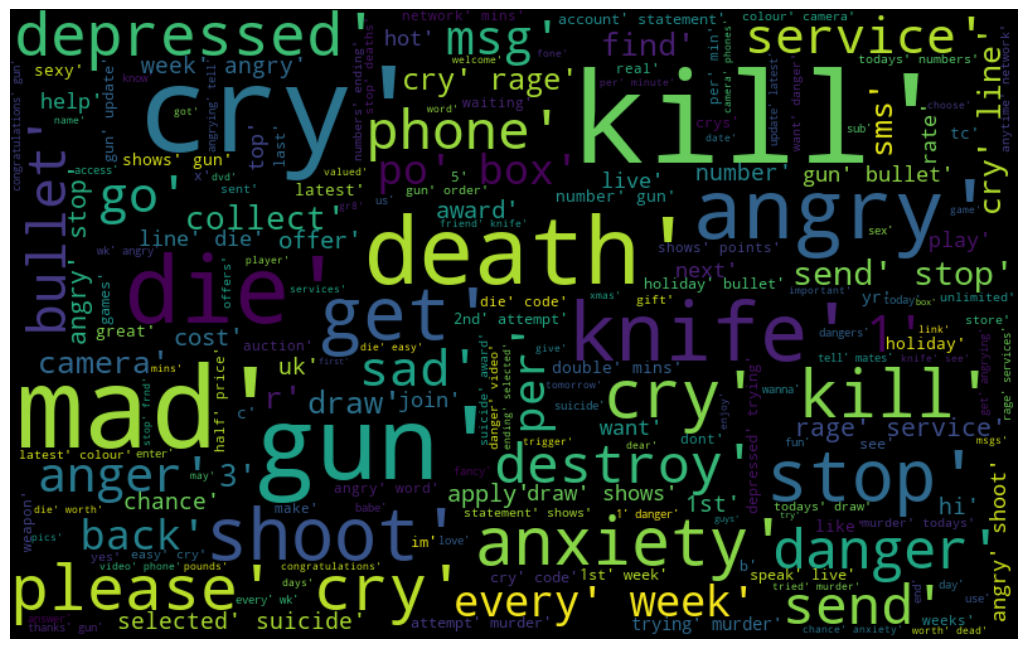

In [186]:
# REQUIREMENT 1 0f 3 Data Visualizations
# wordcloud generation
most_common_alert_words = [w for w in train_alert_words if w in filtered_words]
wordcloud = WordCloud(width=800, height=500, random_state=123, max_font_size=100,).generate(str(most_common_alert_words))
plt.figure(1, figsize=(13, 10))
fig_text = plt.figure(1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.margins(x=0, y=0)
plt.show()

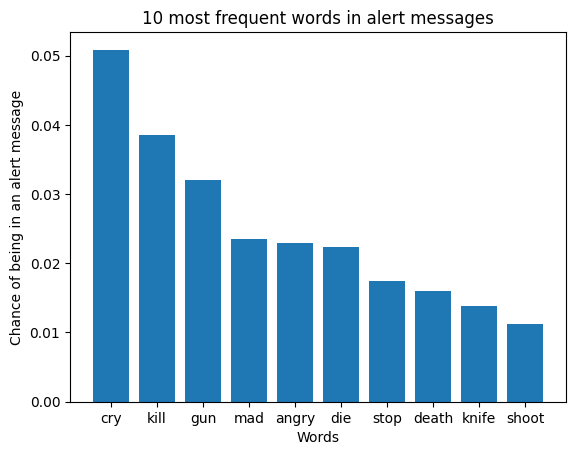

In [187]:
# REQUIREMENT 2 0f 3 Data Visualizations
# Bar graph of 10 most frequent words in alert messages
# Assign the Counter instance `most_common` call to a variable:
word_frequency = Counter(" ".join(most_common_alert_words).split()).most_common(10)

# `most_common` returns a list of (word, count) tuples
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]
total_words = len(most_common_alert_words)
percentages = []

for count in counts:
    new = count/total_words
    percentages.append(new)

plt.bar(words, percentages)
plt.title("10 most frequent words in alert messages")
plt.ylabel("Chance of being in an alert message")
plt.xlabel("Words")
plt.show()

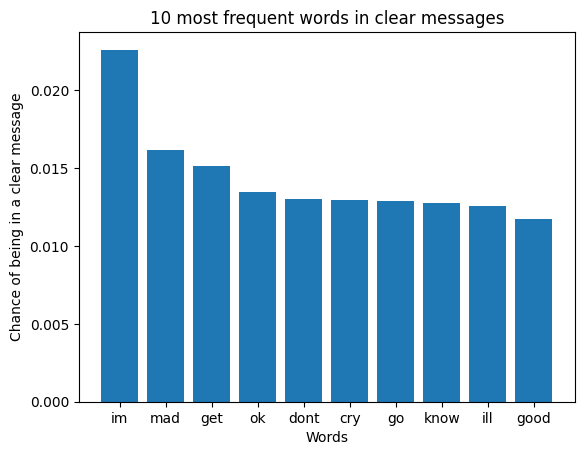

In [188]:
# REQUIREMENT 3 0f 3 Data Visualizations
# Bar graph of 10 most frequent words in alert messages
most_common_clear_words = [w for w in train_clear_words if w in filtered_words]

# Assign the Counter instance `most_common` call to a variable:
word_frequency = Counter(" ".join(most_common_clear_words).split()).most_common(10)

# `most_common` returns a list of (word, count) tuples
words = [word for word, _ in word_frequency]
counts = [counts for _, counts in word_frequency]
total_words = len(most_common_clear_words)
percentages = []

for count in counts:
    new = count/total_words
    percentages.append(new)

plt.bar(words, percentages)
plt.title("10 most frequent words in clear messages")
plt.ylabel("Chance of being in a clear message")
plt.xlabel("Words")
plt.show()

In [189]:
# REQUIREMENT MET - implementation of interactive queries
# Interactive Query
def make_a_prediction():
    #ask if user wants a detailed report
    print("Would you like a detailed report along with the prediction? y or n")
    detailed = input()
    if(detailed.lower().__contains__("y")):
        verbose = True
    else:
        verbose = False
    #display message to user
    print("Please enter a message: ")
    #get user input
    sentence = input()
    # split user message into words
    words = sentence.lower().split()
    predict_alert(words, verbose)

In [190]:
# REQUIREMENT MET - implementation of interactive queries
# Interactive Query
make_a_prediction()

Would you like a detailed report along with the prediction? y or n
Please enter a message: 
       word  alert_prob  clear_prob      ratio
0        im    0.000767    0.006326   0.121286
1  bringing    0.000077    0.000062   1.233075
2       gun    0.012967    0.000187  69.463226
3  tomorrow    0.000460    0.001162   0.396346
Alert Score: -30.655732510186446
Clear Score: -30.240690597878682
['im', 'bringing', 'a', 'gun', 'to', 'school', 'tomorrow']
ALERT
Buzzword Found: Automatic Alert
-------
